In [1]:
%run /data/NNDSP/anal/analysis_notebooks/follow_up_analysis/util_setup.ipynb

# Hypothesis 2.4


If systematic differences in data quality across datasets are causing poor cross-dataset performance, then for a model trained on the highest quality dataset, data quality will predict absolute error for subjects from test datasets.

## Setup

In [2]:
## Setup
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [3]:
#project directory
project_dir = Path('/data/NNDSP')
# NNDSP data directories
nndsp_project_dir = Path('/data/NNDSP')
nndsp_bids_dir = nndsp_project_dir.joinpath('bids_2017_07_14_generic')
nndsp_fs_dir = nndsp_project_dir.joinpath('derivatives/fs5.3_subj')
nndsp_bar_dir = nndsp_project_dir.joinpath('derivatives/bar_subj')
nndsp_mriqc_dir = nndsp_project_dir.joinpath('derivatives/mriqc_2018_06_08')
nndsp_pheno_file = nndsp_project_dir.joinpath('anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

# HCP data directories
hcp_project_dir = Path('/data/HCP_preproc')
hcp_bids_dir = hcp_project_dir.joinpath('bids_hcp_1200')
hcp_fs_dir = nndsp_project_dir.joinpath('derivatives/fs_hcp_subj')
hcp_bar_dir = nndsp_project_dir.joinpath('derivatives/bar_hcp_subj')
hcp_mriqc_dir = hcp_project_dir.joinpath('mriqc_hcp_2018_07_22')
hcp_pheno_file = nndsp_project_dir.joinpath('nino/HCP_ages.csv')
hcp_pheno2_file = nndsp_project_dir.joinpath('anal/analysis_notebooks/phenotype_files/hcp_unrestricted.csv')

# NKI data directories
nki_project_dir = nndsp_project_dir
nki_bids_dir = nki_project_dir.joinpath('anal/NKI')
nki_fs_dir = nki_project_dir.joinpath('derivatives/fs_nki_subj')
nki_bar_dir = nki_project_dir.joinpath('derivatives/bar_nki_subj')
nki_mriqc_dir = nki_project_dir.joinpath('derivatives/mriqc_nki_2018_07_16')
nki_pheno_file = nki_project_dir.joinpath('anal/analysis_notebooks/phenotype_files/participants.tsv')

# CoRR data directories
corr_project_dir = Path('/data/DSST/CoRR')
corr_bids_dir = corr_project_dir.joinpath('bids_corr')
corr_fs_dir = corr_project_dir.joinpath('derivatives/fs_corr')
corr_bar_dir = corr_project_dir.joinpath('derivatives/bar_corr/baracus')
corr_mriqc_dir = corr_project_dir.joinpath('derivatives/mriqc_corr')
corr_pheno_file = corr_project_dir.joinpath('phenotype_files/corr_ages.csv')

# SALD data directories
sald_project_dir = Path('/data/DSST/SALD')
sald_bids_dir = sald_project_dir.joinpath('bids_sald')
sald_fs_dir = sald_project_dir.joinpath('derivatives/fs_sald')
sald_bar_dir = sald_project_dir.joinpath('derivatives/bar_sald/baracus')
sald_mriqc_dir = sald_project_dir.joinpath('derivatives/mriqc_sald')
sald_pheno_file = sald_project_dir.joinpath('phenotype_files/sub_information.xlsx')

In [4]:
## Load MRIQC Json Files
import json
import re
df_nndsp = mriqc_df(nndsp_mriqc_dir, nndsp_pheno_file, data='NNDSP', data_class = 3, 
                    merge_df = (nndsp_subjectdata(nndsp_fs_dir, nndsp_pheno_file)[['subject', 'sex', 'age']]))
df_hcp = mriqc_df(hcp_mriqc_dir, hcp_pheno_file, data='HCP', data_class = 4, 
                 merge_df = (hcp_subjectdata(hcp_fs_dir, hcp_pheno_file, hcp_pheno2_file)[['subject', 'sex', 'age']]))
df_nki = mriqc_df(nki_mriqc_dir, nki_pheno_file, data='NKI', data_class = 5,
                 merge_df = (nki_subjectdata(nki_fs_dir, nki_pheno_file)[['subject', 'sex', 'age']]))
df_corr = mriqc_df(corr_mriqc_dir, corr_pheno_file, data='CoRR', data_class = 6, 
                  merge_df = (corr_subjectdata(corr_fs_dir, corr_pheno_file)[['subject','sex', 'age']]))
df_sald = mriqc_df(sald_mriqc_dir, sald_pheno_file, data='SALD', data_class = 7,
                  merge_df = (sald_subjectdata(sald_fs_dir, sald_pheno_file)[['subject', 'sex', 'age']]))

True
True


In [5]:
df_all = pd.concat([df_nndsp, df_hcp, df_nki, df_corr, df_sald], axis=0, join='outer', sort=False)
df_all.head()

,subject,session_id,acq_id,run_id,cjv,cnr,efc,fber,fwhm_avg,fwhm_x,...,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max,dataset,data_class,sex,age
0,102,1,0.0,1.0,0.450745,2.966345,0.731650,26904.433594,3.339224,3.681080,...,1081.648413,49.010384,0.222196,0.505360,0.562915,0.424826,NNDSP,3,2,28.542094
1,114,1,0.0,1.0,0.597186,2.285747,0.738215,25883.199219,3.400049,3.794461,...,1084.025879,49.015297,0.213160,0.493546,0.555361,0.398110,NNDSP,3,2,25.957563
2,126,1,0.0,1.0,0.325163,4.105503,0.715936,22670.064453,3.143957,3.302560,...,1096.440839,57.998871,0.202775,0.545467,0.515358,0.378795,NNDSP,3,2,6.015058
3,127,1,0.0,1.0,0.331401,4.022244,0.731355,30989.095703,3.051045,3.257622,...,1095.220068,57.538391,0.199213,0.536563,0.520068,0.380536,NNDSP,3,2,7.926078
4,133,1,0.0,1.0,0.374933,3.617528,0.634474,8574.626953,3.196221,3.525169,...,1068.836938,43.263741,0.192762,0.516845,0.550855,0.458206,NNDSP,3,1,22.168378


In [6]:
dataset_mapping = {
    '3' : 'nndsp',
    '4' : 'hcp',
    '5' : 'nki',
    '6' : 'corr',
    '7' : 'sald'
}

In [7]:
dataclass_mapping = {v: k for k, v in dataset_mapping.items()}

In [8]:
%store -r df_gh
%store -r metrics

## Identify Best Dataset

In [9]:
# as outlined in http://mriqc.readthedocs.io/en/stable/iqms/t1w.html
# qc metrics where lower values are better
lower_vals = ['cjv', 'efc', 'fwhm_avg','fwhm_x','fwhm_y','fwhm_z','qi_1', 'qi_2', 'rpve_csf', 'rpve_gm', 'rpve_wm']
# qc metrics where higher values are better
higher_vals = ['cnr', 'snr_csf', 'snr_gm', 'snr_total', 'snr_wm','snrd_csf','snrd_gm', 'snrd_total','snrd_wm',
               'fber']
# other
icvs = ['icvs_csf','icvs_gm','icvs_wm'] # normative range
inu = ['inu_med'] # values close to 1 are best
wm2max = ['wm2max'] # values in interval [0.6, 0.8]

In [35]:
best_dataset_per_metric = {}
for metric in metrics:
    groups = []
    data_to_group = []
    
    # put all the qc values for 
    for data_class in df_all.data_class.drop_duplicates():
        group = df_all[df_all.data_class == data_class][metric].dropna().tolist()
        groups.append(group)
        data_to_group.append(data_class)
    
    if metric in lower_vals:
        min_mean = np.mean(groups[0])
        min_dataset = data_to_group[0]
        
        for i in range(0, len(groups)):
            if np.mean(groups[i]) <= min_mean:
                min_mean = np.mean(groups[i])
                min_dataset = data_to_group[i]
        
        best_dataset_per_metric[metric] = [dataset_mapping[str(min_dataset)], min_mean]
        
    elif metric in higher_vals:
            
        max_mean = np.mean(groups[0])
        max_dataset = data_to_group[0]
        
        # find the one with the mighest mean value
        for i in range(0, len(groups)):
            if np.mean(groups[i]) >= max_mean:
                max_mean = np.mean(groups[i])
                max_dataset = data_to_group[i]
        
        best_dataset_per_metric[metric] = [dataset_mapping[str(max_dataset)], max_mean]
        
    elif metric in inu:
            
        min_one = abs(1-np.mean(groups[0]))
        min_one_dataset = data_to_group[0]
        
        # find the closest to 1
        for i in range(0, len(groups)):
            if abs(1-np.mean(groups[i])) <= min_one:
                min_one = abs(1-np.mean(groups[i]))
                min_one_dataset = data_to_group[i]
        
        best_dataset_per_metric[metric] = [dataset_mapping[str(min_one_dataset)], min_one]
        
    elif metric in wm2max:
        
        interval = min(abs(0.8 - np.mean(groups[0])) , abs(0.6 - np.mean(groups[0])))
        interval_dataset = data_to_group[0]

        if np.mean(groups[0]) <= 0.8 and np.mean(groups[0]) >= 0.6:
            is_interval = True
        else:
            is_interval = False
        
        # find the closest to 1
        for i in range(0, len(groups)):
            if is_interval == True:
                if min(abs(0.8 - np.mean(groups[i])) , abs(0.6 - np.mean(groups[i]))) <= interval and np.mean(groups[i]) <= 0.8 and np.mean(groups[i]) >= 0.6:
                    interval = min(abs(0.8 - np.mean(groups[i])) , abs(0.6 - np.mean(groups[i])))
                    interval_dataset = data_to_group[i]
            else:
                if ((min(abs(0.8 - np.mean(groups[i])) , abs(0.6 - np.mean(groups[i]))) <= interval) or (np.mean(groups[i]) <= 0.8 and np.mean(groups[i]) >= 0.6)):
                    interval = min(abs(0.8 - np.mean(groups[i])) , abs(0.6 - np.mean(groups[i])))
                    interval_dataset = data_to_group[i]
        
        best_dataset_per_metric[metric] = [dataset_mapping[str(interval_dataset)], interval]
        
    else:
        continue

### Review of Identified Best Dataset

In [11]:
for key, item in best_dataset_per_metric.items():
    datasets = ['nndsp', 'hcp', 'nki', 'corr', 'sald']
    datasets.remove(item[0])
    
    other_contenders = []
    for dataset in datasets:
        
        if (item[0] + ':' + dataset) in df_gh.pairs.tolist():
            pair = (item[0] + ':' + dataset)
            
            if df_gh[df_gh.pairs == pair][key].values[0] >= 0.05:
                print("Review", item[0], "as the best dataset compared to", dataset, "on", key)
                other_contenders.append(dataset)     
                
        elif (dataset + ':' + item[0]) in df_gh.pairs.tolist():
            pair = (dataset + ':' + item[0])
            
            if df_gh[df_gh.pairs == pair][key].values[0] >= 0.05:
                print("Review", item[0], "as the best dataset compared to", dataset, "on", key)
                other_contenders.append(dataset)
                
        else:
            print("Error: Could not find pair", (dataset + ':' + item[0]), "in DataFrame")
    
    if len(other_contenders) > 0:
        print("***REVIEW", key, item[0],'***\n')

Review nndsp as the best dataset compared to hcp on fber
Review nndsp as the best dataset compared to nki on fber
Review nndsp as the best dataset compared to corr on fber
Review nndsp as the best dataset compared to sald on fber
***REVIEW fber nndsp ***

Review sald as the best dataset compared to nki on snr_wm
***REVIEW snr_wm sald ***

Review nndsp as the best dataset compared to hcp on snrd_csf
Review nndsp as the best dataset compared to nki on snrd_csf
Review nndsp as the best dataset compared to corr on snrd_csf
Review nndsp as the best dataset compared to sald on snrd_csf
***REVIEW snrd_csf nndsp ***

Review nndsp as the best dataset compared to hcp on snrd_gm
Review nndsp as the best dataset compared to nki on snrd_gm
Review nndsp as the best dataset compared to corr on snrd_gm
Review nndsp as the best dataset compared to sald on snrd_gm
***REVIEW snrd_gm nndsp ***

Review nndsp as the best dataset compared to hcp on snrd_total
Review nndsp as the best dataset compared to nki 

In [12]:
# hcp has the best qc on fber because it has the smallest range and the smallest median
df_gh[['pairs', 'fber']]
for data_class in df_all.data_class.drop_duplicates():
    group = df_all[df_all.data_class == data_class]['fber'].tolist()
    print(max(group)-min(group), np.median(group), data_class)

360500.62565612793 12967.802734375 3
976.8838195800781 732.336669921875 4
37205.94182109833 12829.91748046875 5
17450.11555480957 930.6400146484374 6
3214.3240966796875 2521.15966796875 7


In [13]:
# sald is still the winner here, because it has a smaller range and a higher median than nki
df_gh[['pairs', 'snr_wm']]
for data_class in [5,7]:
    group = df_all[df_all.data_class == data_class]['snr_wm'].tolist()
    print(max(group)-min(group), np.median(group), data_class)

21.598871637684255 22.475583649758235 5
11.584121511025753 22.299836836526183 7


In [14]:
# nndsp is still the winner
df_gh[['pairs', 'snrd_csf']]
for data_class in df_all.data_class.drop_duplicates():
    group = df_all[df_all.data_class == data_class]['snrd_csf'].tolist()
    print(max(group)-min(group), np.median(group), data_class)

265.1077520604715 56.25948928038987 3
18.71854951319637 18.79509277299288 4
227.16748091460644 48.43272742690487 5
93.1042428890948 17.383064678203645 6
20.095353036346328 26.677273719643196 7


In [15]:
# nndsp is still the winner
df_gh[['pairs', 'snrd_gm']]
for data_class in df_all.data_class.drop_duplicates():
    group = df_all[df_all.data_class == data_class]['snrd_gm'].tolist()
    print(max(group)-min(group), np.median(group), data_class)

426.7103759593013 108.70049261769094 3
31.911093725712746 40.351431628423256 4
182.84364319880325 98.50221335640543 5
172.75422578111784 36.707266344725525 6
37.2984456364408 54.36244626440626 7


In [16]:
# nndsp is still the winner
df_gh[['pairs', 'snrd_total']]
for data_class in df_all.data_class.drop_duplicates():
    group = df_all[df_all.data_class == data_class]['snrd_total'].tolist()
    print(max(group)-min(group), np.median(group), data_class)

425.1668349758079 105.8643336570176 3
31.212131102232714 37.300140837492435 4
179.01761574937606 92.18700240685851 5
159.31908792901208 35.98354886687524 6
34.214338644036914 50.62700465671605 7


In [17]:
# nndsp is still the winner
df_gh[['pairs', 'snrd_wm']]
for data_class in df_all.data_class.drop_duplicates():
    group = df_all[df_all.data_class == data_class]['snrd_wm'].tolist()
    print(max(group)-min(group), np.median(group), data_class)

620.6095726129146 152.90294931699475 3
45.35421562969718 52.61197366794827 4
244.66631819432217 129.90426728367498 5
212.36805752053536 53.89663247182371 6
49.730212786777564 70.51481223619035 7


### Worst Dataset

In [36]:
worst_dataset_per_metric = {}
for metric in metrics:
    groups = []
    data_to_group = []
    
    # put all the qc values for 
    for data_class in df_all.data_class.drop_duplicates():
        group = df_all[df_all.data_class == data_class][metric].dropna().tolist()
        groups.append(group)
        data_to_group.append(data_class)
    
    if metric in lower_vals:
        min_mean = np.mean(groups[0])
        min_dataset = data_to_group[0]
        
        for i in range(0, len(groups)):
            if np.mean(groups[i]) >= min_mean:
                min_mean = np.mean(groups[i])
                min_dataset = data_to_group[i]
        
        worst_dataset_per_metric[metric] = [dataset_mapping[str(min_dataset)], min_mean]
        
    elif metric in higher_vals:
            
        max_mean = np.mean(groups[0])
        max_dataset = data_to_group[0]
        
        # find the one with the mighest mean value
        for i in range(0, len(groups)):
            if np.mean(groups[i]) <= max_mean:
                max_mean = np.mean(groups[i])
                max_dataset = data_to_group[i]
        
        worst_dataset_per_metric[metric] = [dataset_mapping[str(max_dataset)], max_mean]
        
    elif metric in inu:
            
        min_one = abs(1-np.mean(groups[0]))
        min_one_dataset = data_to_group[0]
        
        # find the closest to 1
        for i in range(0, len(groups)):
            if abs(1-np.mean(groups[i])) >= min_one:
                min_one = abs(1-np.mean(groups[i]))
                min_one_dataset = data_to_group[i]
        
        worst_dataset_per_metric[metric] = [dataset_mapping[str(min_one_dataset)], min_one]
        
    elif metric in wm2max:
        
        interval = min(abs(0.8 - np.mean(groups[0])) , abs(0.6 - np.mean(groups[0])))
        interval_dataset = data_to_group[0]

        if np.mean(groups[0]) >= 0.8 and np.mean(groups[0]) <= 0.6:
            is_interval = True
        else:
            is_interval = False
        
        # find the closest to 1
        for i in range(0, len(groups)):
            if is_interval == True:
                if min(abs(0.8 - np.mean(groups[i])) , abs(0.6 - np.mean(groups[i]))) >= interval and np.mean(groups[i]) >= 0.8 and np.mean(groups[i]) <= 0.6:
                    interval = min(abs(0.8 - np.mean(groups[i])) , abs(0.6 - np.mean(groups[i])))
                    interval_dataset = data_to_group[i]
            else:
                if ((min(abs(0.8 - np.mean(groups[i])) , abs(0.6 - np.mean(groups[i]))) >= interval) or (np.mean(groups[i]) >= 0.8 and np.mean(groups[i]) <= 0.6)):
                    interval = min(abs(0.8 - np.mean(groups[i])) , abs(0.6 - np.mean(groups[i])))
                    interval_dataset = data_to_group[i]
        
        worst_dataset_per_metric[metric] = [dataset_mapping[str(interval_dataset)], interval]
        
    else:
        continue

In [92]:
df_worst = pd.DataFrame([])
df_worst['qc_metric'] = worst_dataset_per_metric.keys()
df_worst['worst'] = [item[0] for key, item in worst_dataset_per_metric.items()]
df_worst['best'] = [item[0] for key, item in best_dataset_per_metric.items()]

In [93]:
df_worst

,qc_metric,worst,best
0,cjv,hcp,corr
1,cnr,hcp,corr
2,efc,sald,hcp
3,fber,hcp,nndsp
4,fwhm_avg,hcp,nndsp
5,fwhm_x,hcp,nndsp
6,fwhm_y,hcp,nndsp
7,fwhm_z,hcp,nndsp
8,inu_med,sald,nndsp
9,qi_1,nki,sald


In [37]:
worst_dataset_per_metric

{'cjv': ['hcp', 0.6373246616944664],
 'cnr': ['hcp', 2.189899218260179],
 'efc': ['sald', 0.6939937412663707],
 'fber': ['hcp', 747.3919669714542],
 'fwhm_avg': ['hcp', 4.958321330750106],
 'fwhm_x': ['hcp', 4.921562214447415],
 'fwhm_y': ['hcp', 4.8848682182212535],
 'fwhm_z': ['hcp', 5.06853355958165],
 'inu_med': ['sald', 0.08087222155741447],
 'qi_1': ['nki', 0.000863233329731089],
 'qi_2': ['nki', 0.0231950549542499],
 'rpve_csf': ['nki', 28.44846703739811],
 'rpve_gm': ['nki', 13.855060233564272],
 'rpve_wm': ['corr', 18.22186340304861],
 'snr_csf': ['nndsp', 1.5384370853224623],
 'snr_gm': ['corr', 10.20417642951915],
 'snr_total': ['hcp', 8.66642265953261],
 'snr_wm': ['hcp', 12.818324419919188],
 'snrd_csf': ['corr', 18.745832961074402],
 'snrd_gm': ['corr', 37.61906389233343],
 'snrd_total': ['corr', 36.91970996983576],
 'snrd_wm': ['hcp', 53.277580570798534],
 'wm2max': ['nndsp', 0.17621316642701074]}

In [38]:
best_dataset_per_metric

{'cjv': ['corr', 0.3831961972863085],
 'cnr': ['corr', 3.543762902267771],
 'efc': ['hcp', 0.6029179151785039],
 'fber': ['nndsp', 31199.964215830547],
 'fwhm_avg': ['nndsp', 3.288194305254119],
 'fwhm_x': ['nndsp', 3.532598075729896],
 'fwhm_y': ['nndsp', 3.6842980419632205],
 'fwhm_z': ['nndsp', 2.6476867980692416],
 'inu_med': ['nndsp', 0.01214452145777356],
 'qi_1': ['sald', 8.066600620323844e-06],
 'qi_2': ['hcp', 0.0006781220107601263],
 'rpve_csf': ['sald', 14.23189503702726],
 'rpve_gm': ['sald', 7.186702559243416],
 'rpve_wm': ['sald', 9.146429468474562],
 'snr_csf': ['sald', 3.3845227393684914],
 'snr_gm': ['nki', 13.70641389782399],
 'snr_total': ['nki', 12.996206172045746],
 'snr_wm': ['sald', 22.203041301515707],
 'snrd_csf': ['nndsp', 78.0797593492954],
 'snrd_gm': ['nndsp', 150.14167582612708],
 'snrd_total': ['nndsp', 147.6622157955715],
 'snrd_wm': ['nndsp', 214.76521221129207],
 'wm2max': ['corr', 0.0085977653616236]}

## Train Models

In [18]:
%run /data/NNDSP/anal/analysis_notebooks/follow_up_analysis/util_models.ipynb

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
df_nndsp = nndsp_subjectdata(nndsp_fs_dir, nndsp_pheno_file)
df_hcp = hcp_subjectdata(hcp_fs_dir, hcp_pheno_file, hcp_pheno2_file)
df_nki = nki_subjectdata(nki_fs_dir, nki_pheno_file)
df_corr = corr_subjectdata(corr_fs_dir, corr_pheno_file)
df_sald = sald_subjectdata(sald_fs_dir, sald_pheno_file)

In [20]:
print("Features for NNDSP")
x, nndsp_features = subject_features([os.path.basename(s) for s in df_nndsp.subj_paths], nndsp_bar_dir)
print("Features for HCP")
x, hcp_features = subject_features([os.path.basename(s) for s in df_hcp.subj_paths], hcp_bar_dir)
print("Features for NKI")
x, nki_features = subject_features([os.path.basename(s) for s in df_nki.subj_paths], nki_bar_dir)
print("Features for CoRR")
x, corr_features = subject_features([os.path.basename(s) for s in df_corr.subj_paths], corr_bar_dir, session='_ses-1')
print("Features for SALD")
x, sald_features = subject_features([os.path.basename(s) for s in df_sald.subj_paths], sald_bar_dir)

Features for NNDSP
Features for HCP
Features for NKI
Features for CoRR
Features for SALD


In [21]:
datasets_info = {
    'nndsp' : [df_nndsp, nndsp_bar_dir, nndsp_features, True, ''],
    'hcp' : [df_hcp, hcp_bar_dir, hcp_features, True, ''],
    'nki' : [df_nki, nki_bar_dir, nki_features, False, ''],
    'corr' : [df_corr, corr_bar_dir, corr_features, True, '_ses-1'],
    'sald' : [df_sald, sald_bar_dir, sald_features, True, '']
}

### Train NNDSP

In [22]:
data = datasets_info['nndsp']
print("Training Complex for NNDSP")
scores, df_complex_train, df_complex_test, nndsp_complex_pipes = complex_model(data[0], data[1], features = data[2],
                                                                         is_int = data[3], session = data[4])

Training Complex for NNDSP

Cortical Thickness Pipeline
Mean Absolute Error (Train, thickness): 0.10002546998324104
Mean Absolute Error (Test, thickness): 5.610520423976985

Subcortival Volumes Pipeline
Mean Absolute Error (Train, aseg): 4.22411832276357
Mean Absolute Error (Test, aseg): 5.144581607047744

Cortical Surface Area Pipeline
Mean Absolute Error (Train, area): 0.09969376571826548
Mean Absolute Error (Test, area): 7.763296850019713

Stacking predictions
Beginning Random Forest
Fitting stacking model
best max_depth: 7
Mean Absolute Error (Train): 2.3301168303352537
Mean Absolute Error (Test): 4.1749261755371645
                     r2     rpear    rpear2       mae     medae
aseg           0.734802  0.870348  0.757506  5.144582  3.474862
ct             0.732144  0.859644  0.738988  5.610520  4.151850
ca             0.546552  0.744444  0.554196  7.763297  6.333068
mean_pred      0.758793  0.895219  0.801416  5.253943  4.126407
pred_age_test  0.849809  0.922612  0.851213  4.17492

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:111: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:112: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:113: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/en

In [23]:
print("\n\nTraining Simple for NNDSP")
simple_train, df_simple_test, nndsp_simple_pipe = simple_model(data[0], data[1], model_train = df_complex_train,
                                                               model_test=df_complex_test, is_int = data[3],
                                                               session = data[4])



Training Simple for NNDSP
Finding Subjects
Extracting Features
431
Training Model
Mean Absolute Error (Train): 6.741568497331485
Mean Absolute Error (Test): 6.6158615158264


### Train HCP

In [24]:
data = datasets_info['hcp']
print("Training Complex for HCP")
scores, df_complex_train, df_complex_test, hcp_complex_pipes = complex_model(data[0], data[1], features = data[2],
                                                                         is_int = data[3], session = data[4])

print("\n\nTraining Simple for NNDSP")
simple_train, df_simple_test, hcp_simple_pipe = simple_model(data[0], data[1], model_train = df_complex_train,
                                                               model_test=df_complex_test, is_int = data[3],
                                                               session = data[4])

Training Complex for HCP

Cortical Thickness Pipeline
Mean Absolute Error (Train, thickness): 0.09853049384187654
Mean Absolute Error (Test, thickness): 2.8497195028860363

Subcortival Volumes Pipeline
Mean Absolute Error (Train, aseg): 2.327114580579501
Mean Absolute Error (Test, aseg): 2.8263745209104445

Cortical Surface Area Pipeline
Mean Absolute Error (Train, area): 0.09912496038633972
Mean Absolute Error (Test, area): 3.17179860841185

Stacking predictions
Beginning Random Forest
Fitting stacking model
best max_depth: 2


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:111: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:112: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:113: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/en

Mean Absolute Error (Train): 2.638009354175349
Mean Absolute Error (Test): 2.748846971557294
                     r2     rpear    rpear2       mae     medae
aseg           0.100067  0.414964  0.172195  2.826375  2.418410
ct             0.125001  0.395706  0.156583  2.849720  2.550103
ca            -0.077819  0.227324  0.051676  3.171799  2.690733
mean_pred      0.219979  0.487052  0.237219  2.700890  2.385161
pred_age_test  0.182106  0.452411  0.204675  2.748847  2.407343


Training Simple for NNDSP
Finding Subjects
Extracting Features
895
Training Model
Mean Absolute Error (Train): 2.888798258464496
Mean Absolute Error (Test): 2.8225353413590346


### Train NKI

In [25]:
data = datasets_info['nki']
print("Training Complex for NKI")
scores, df_complex_train, df_complex_test, nki_complex_pipes = complex_model(data[0], data[1], features = data[2],
                                                                         is_int = data[3], session = data[4])

print("\n\nTraining Simple for NKI")
simple_train, df_simple_test, nki_simple_pipe = simple_model(data[0], data[1], model_train = df_complex_train,
                                                               model_test=df_complex_test, is_int = data[3],
                                                               session = data[4])

Training Complex for NKI

Cortical Thickness Pipeline
Mean Absolute Error (Train, thickness): 0.09920035853008527
Mean Absolute Error (Test, thickness): 7.495256590446333

Subcortival Volumes Pipeline
Mean Absolute Error (Train, aseg): 6.933389124521699
Mean Absolute Error (Test, aseg): 7.599600913134387

Cortical Surface Area Pipeline
Mean Absolute Error (Train, area): 0.0998267507980057
Mean Absolute Error (Test, area): 10.055971695072952

Stacking predictions
Beginning Random Forest
Fitting stacking model
best max_depth: 5


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:111: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:112: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:113: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/en

Mean Absolute Error (Train): 4.371830926251227
Mean Absolute Error (Test): 5.634650429993011
                     r2     rpear    rpear2        mae     medae
aseg           0.796643  0.893552  0.798434   7.599601  5.926389
ct             0.812782  0.901785  0.813215   7.495257  6.382004
ca             0.675172  0.823510  0.678168  10.055972  8.880205
mean_pred      0.850697  0.929052  0.863138   6.708837  5.692882
pred_age_test  0.880609  0.940931  0.885351   5.634650  4.205934


Training Simple for NKI
Finding Subjects
Extracting Features
808
Training Model
Mean Absolute Error (Train): 10.39709013717111
Mean Absolute Error (Test): 10.486397677580436


### Train CoRR

In [26]:
data = datasets_info['corr']
print("Training Complex for CoRR")
scores, df_complex_train, df_complex_test, corr_complex_pipes = complex_model(data[0], data[1], features = data[2],
                                                                         is_int = data[3], session = data[4])

print("\n\nTraining Simple for CoRR")
simple_train, df_simple_test, corr_simple_pipe = simple_model(data[0], data[1], model_train = df_complex_train,
                                                               model_test=df_complex_test, is_int = data[3],
                                                               session = data[4])

Training Complex for CoRR

Cortical Thickness Pipeline
Mean Absolute Error (Train, thickness): 0.09977061821805991
Mean Absolute Error (Test, thickness): 6.75645415360145

Subcortival Volumes Pipeline
Mean Absolute Error (Train, aseg): 5.663815391649642
Mean Absolute Error (Test, aseg): 5.992394415515624

Cortical Surface Area Pipeline
Mean Absolute Error (Train, area): 0.09981088235803484
Mean Absolute Error (Test, area): 8.43916728791637

Stacking predictions
Beginning Random Forest
Fitting stacking model
best max_depth: 5


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:111: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:112: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:113: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/en

Mean Absolute Error (Train): 3.0709277322560324
Mean Absolute Error (Test): 3.7736571041214684
                     r2     rpear    rpear2       mae     medae
aseg           0.697211  0.845274  0.714487  5.992394  4.102497
ct             0.602094  0.786930  0.619260  6.756454  5.281924
ca             0.536461  0.737237  0.543519  8.439167  7.015198
mean_pred      0.749966  0.876363  0.768013  5.506313  3.856642
pred_age_test  0.863476  0.929544  0.864053  3.773657  2.494256


Training Simple for CoRR
Finding Subjects
Extracting Features
1467
Training Model
Mean Absolute Error (Train): 7.592307143118568
Mean Absolute Error (Test): 7.375877042418004


### Train SALD

In [27]:
data = datasets_info['sald']
print("Training Complex for SALD")
scores, df_complex_train, df_complex_test, sald_complex_pipes = complex_model(data[0], data[1], features = data[2],
                                                                         is_int = data[3], session = data[4])

print("\n\nTraining Simple for SALD")
simple_train, df_simple_test, sald_simple_pipe = simple_model(data[0], data[1], model_train = df_complex_train,
                                                               model_test=df_complex_test, is_int = data[3],
                                                               session = data[4])

Training Complex for SALD

Cortical Thickness Pipeline
Mean Absolute Error (Train, thickness): 0.09955500707388659
Mean Absolute Error (Test, thickness): 8.520583572643233

Subcortival Volumes Pipeline
Mean Absolute Error (Train, aseg): 4.753543483063187
Mean Absolute Error (Test, aseg): 6.969631918396

Cortical Surface Area Pipeline
Mean Absolute Error (Train, area): 0.10003195110829972
Mean Absolute Error (Test, area): 10.09032735273134

Stacking predictions
Beginning Random Forest
Fitting stacking model
best max_depth: 3


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:111: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:112: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:113: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/en

Mean Absolute Error (Train): 4.682971625197072
Mean Absolute Error (Test): 6.566899294248159
                     r2     rpear    rpear2        mae     medae
aseg           0.704745  0.841277  0.707748   6.969632  5.280955
ct             0.609537  0.783130  0.613293   8.520584  7.582037
ca             0.414496  0.643887  0.414591  10.090327  8.773173
mean_pred      0.715444  0.865104  0.748405   7.106441  6.754906
pred_age_test  0.698058  0.838475  0.703040   6.566899  4.943710


Training Simple for SALD
Finding Subjects
Extracting Features
195
Training Model
Mean Absolute Error (Train): 9.090006073635035
Mean Absolute Error (Test): 9.399690970250266


## Get Mean Absolute Error

In [28]:
models = {
    'nndsp' : [nndsp_complex_pipes, nndsp_simple_pipe],
    'hcp' : [hcp_complex_pipes, hcp_simple_pipe],
    'nki' : [nki_complex_pipes, nki_simple_pipe],
    'corr' : [corr_complex_pipes, corr_simple_pipe],
    'sald' : [sald_complex_pipes, sald_simple_pipe],
}

In [30]:
df_mae = df_all[['subject', 'data_class', 'session_id', 'acq_id', 'run_id', 'sex', 'age']]

for metric, data in best_dataset_per_metric.items():
    df_mae[metric] = pd.merge(pd.DataFrame(df_mae['subject'], columns=['subject']), df_all[['subject', metric]], 
                              on='subject')[metric]
    
    print("Testing for", metric, "using ", data[0])
    
    datasets = ['nndsp', 'hcp', 'nki', 'corr', 'sald']
    
    complex_pipes = models[data[0]][0]
    simple_pipes = models[data[0]][1]
    
    df_metric_maes = pd.DataFrame([], columns=['subject', 'complex_'+metric+'_pred', 'simple_'+metric+'_pred'])
    for test in datasets:
        print("Testing on", test)
        
        test_data = datasets_info[test]
        df_temp = complex_test(test_data[0], test_data[1], complex_pipes, data=test,
                                                   is_int=test_data[3], features=test_data[2], pred = 0, pred_with_subj = 1,
                                                   session = test_data[4])
        df_temp = df_temp.rename(index=str, columns={'complex_pred': 'complex_'+metric+'_pred'})
                             
        df_temp2 =  simple_test(test_data[0], test_data[1], simple_pipes,
                                                          data=test, is_int=test_data[3], pred = 0, pred_with_subj = 1,
                                                          session = test_data[4])
        df_temp2 = df_temp2.rename(columns={'simple_pred': 'simple_'+metric+'_pred'})
                                   
        df_temp = pd.merge(df_temp, df_temp2, on='subject')
        df_metric_maes = pd.concat([df_metric_maes, df_temp], join='outer', sort=False)
    
    df_mae = df_mae.merge(df_metric_maes, on='subject')

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Testing for cjv using  corr
Testing on nndsp
431
431
Predicting from Pipelines
Mean Absolute Error (nndsp thickness): 7.069465646693021
Mean Absolute Error (nndsp aseg): 5.50594454098291
Mean Absolute Error (nndsp area): 8.083805054410133
Mean Absolute Error (nndsp stack): 5.398258755896415
Finding Subjects
431
431
Extracting Features
431
Predicting Pipes
Mean Absolute Error (nndsp simple): 7.616207205748459
Testing on hcp
895
895
Predicting from Pipelines
Mean Absolute Error (hcp thickness): 5.331180633870456
Mean Absolute Error (hcp aseg): 5.318864795959458
Mean Absolute Error (hcp area): 8.000414582687165
Mean Absolute Error (hcp stack): 5.303584441759756
Finding Subjects
895
895
Extracting Features
895
Predicting Pipes
Mean Absolute Error (hcp simple): 8.090834663823998
Testing on nki
808
808
Predicting from Pipelines
Mean Absolute Error (nki thickness): 9.806260467775772
Mean Absolute Error (nki aseg): 11.849147631651265
Mean Absolute Error (nki area): 12.333906738484412
Mean Abso

Mean Absolute Error (hcp thickness): 5.440039016836559
Mean Absolute Error (hcp aseg): 5.914060722674945
Mean Absolute Error (hcp area): 5.853192574321688
Mean Absolute Error (hcp stack): 5.524139214925102
Finding Subjects
895
895
Extracting Features
895
Predicting Pipes
Mean Absolute Error (hcp simple): 9.826246004843025
Testing on nki
808
808
Predicting from Pipelines
Mean Absolute Error (nki thickness): 11.345823145363893
Mean Absolute Error (nki aseg): 13.704990930891261
Mean Absolute Error (nki area): 13.258996618112764
Mean Absolute Error (nki stack): 8.621532096471306
Finding Subjects
808
808
Extracting Features
808
Predicting Pipes
Mean Absolute Error (nki simple): 13.508881423504945
Testing on corr
1467
1467
Predicting from Pipelines
Mean Absolute Error (corr thickness): 9.27636810035737
Mean Absolute Error (corr aseg): 7.5504309406130306
Mean Absolute Error (corr area): 16.304535853554526
Mean Absolute Error (corr stack): 6.846867449054776
Finding Subjects
1467
1467
Extractin

Mean Absolute Error (nki area): 13.258996618112764
Mean Absolute Error (nki stack): 8.621532096471306
Finding Subjects
808
808
Extracting Features
808
Predicting Pipes
Mean Absolute Error (nki simple): 13.508881423504945
Testing on corr
1467
1467
Predicting from Pipelines
Mean Absolute Error (corr thickness): 9.27636810035737
Mean Absolute Error (corr aseg): 7.5504309406130306
Mean Absolute Error (corr area): 16.304535853554526
Mean Absolute Error (corr stack): 6.846867449054773
Finding Subjects
1467
1467
Extracting Features
1467
Predicting Pipes
Mean Absolute Error (corr simple): 7.796051091797908
Testing on sald
195
195
Predicting from Pipelines
Mean Absolute Error (sald thickness): 12.163497707906286
Mean Absolute Error (sald aseg): 14.596759745310615
Mean Absolute Error (sald area): 13.075065229419305
Mean Absolute Error (sald stack): 9.219250554737851
Finding Subjects
195
195
Extracting Features
195
Predicting Pipes
Mean Absolute Error (sald simple): 14.97580176447223
Testing for 

1467
1467
Extracting Features
1467
Predicting Pipes
Mean Absolute Error (corr simple): 11.21557669128937
Testing on sald
195
195
Predicting from Pipelines
Mean Absolute Error (sald thickness): 4.331661670795917
Mean Absolute Error (sald aseg): 5.867269978768908
Mean Absolute Error (sald area): 5.1207957939752635
Mean Absolute Error (sald stack): 5.553986767395763
Finding Subjects
195
195
Extracting Features
195
Predicting Pipes
Mean Absolute Error (sald simple): 9.245642585780127
Testing for rpve_wm using  sald
Testing on nndsp
431
431
Predicting from Pipelines
Mean Absolute Error (nndsp thickness): 10.807039773467608
Mean Absolute Error (nndsp aseg): 9.055900467686126
Mean Absolute Error (nndsp area): 13.614886764811455
Mean Absolute Error (nndsp stack): 11.636622834286067
Finding Subjects
431
431
Extracting Features
431
Predicting Pipes
Mean Absolute Error (nndsp simple): 13.213144012004236
Testing on hcp
895
895
Predicting from Pipelines
Mean Absolute Error (hcp thickness): 6.123999

431
431
Predicting from Pipelines
Mean Absolute Error (nndsp thickness): 10.807039773467608
Mean Absolute Error (nndsp aseg): 9.055900467686126
Mean Absolute Error (nndsp area): 13.614886764811455
Mean Absolute Error (nndsp stack): 11.636622834286067
Finding Subjects
431
431
Extracting Features
431
Predicting Pipes
Mean Absolute Error (nndsp simple): 13.213144012004236
Testing on hcp
895
895
Predicting from Pipelines
Mean Absolute Error (hcp thickness): 6.123999017046937
Mean Absolute Error (hcp aseg): 9.465135580591038
Mean Absolute Error (hcp area): 10.868016481749132
Mean Absolute Error (hcp stack): 8.134696459102367
Finding Subjects
895
895
Extracting Features
895
Predicting Pipes
Mean Absolute Error (hcp simple): 7.160030606580395
Testing on nki
808
808
Predicting from Pipelines
Mean Absolute Error (nki thickness): 11.062229222064481
Mean Absolute Error (nki aseg): 10.267295038581262
Mean Absolute Error (nki area): 14.560737570761141
Mean Absolute Error (nki stack): 11.33951868135

Mean Absolute Error (hcp area): 5.853192574321688
Mean Absolute Error (hcp stack): 5.524139214925099
Finding Subjects
895
895
Extracting Features
895
Predicting Pipes
Mean Absolute Error (hcp simple): 9.826246004843025
Testing on nki
808
808
Predicting from Pipelines
Mean Absolute Error (nki thickness): 11.345823145363893
Mean Absolute Error (nki aseg): 13.704990930891261
Mean Absolute Error (nki area): 13.258996618112764
Mean Absolute Error (nki stack): 8.621532096471308
Finding Subjects
808
808
Extracting Features
808
Predicting Pipes
Mean Absolute Error (nki simple): 13.508881423504945
Testing on corr
1467
1467
Predicting from Pipelines
Mean Absolute Error (corr thickness): 9.27636810035737
Mean Absolute Error (corr aseg): 7.5504309406130306
Mean Absolute Error (corr area): 16.304535853554526
Mean Absolute Error (corr stack): 6.846867449054774
Finding Subjects
1467
1467
Extracting Features
1467
Predicting Pipes
Mean Absolute Error (corr simple): 7.796051091797908
Testing on sald
195

In [39]:
df_mae.head()

,subject,data_class,session_id,acq_id,run_id,sex,age,cjv,complex_cjv_pred,simple_cjv_pred,...,simple_snrd_gm_pred,snrd_total,complex_snrd_total_pred,simple_snrd_total_pred,snrd_wm,complex_snrd_wm_pred,simple_snrd_wm_pred,wm2max,complex_wm2max_pred,simple_wm2max_pred
0,102,3,1,0.0,1.0,2,28.542094,0.450745,26.780847,21.800550,...,21.686312,77.090365,24.373487,21.686312,115.659372,24.373487,21.686312,0.424826,26.780847,21.800550
1,114,3,1,0.0,1.0,2,25.957563,0.597186,24.391730,22.216942,...,21.720269,102.697552,25.171104,21.720269,149.708732,25.171104,21.720269,0.398110,24.391730,22.216942
2,126,3,1,0.0,1.0,2,6.015058,0.325163,9.917961,15.519563,...,12.148031,199.485519,9.561267,12.148031,295.042882,9.561267,12.148031,0.378795,9.917961,15.519563
3,127,3,1,0.0,1.0,2,7.926078,0.331401,9.622728,17.295947,...,14.490986,208.846723,10.966533,14.490986,309.144745,10.966533,14.490986,0.380536,9.622728,17.295947
4,133,3,1,0.0,1.0,1,22.168378,0.374933,23.326760,24.351063,...,21.905119,78.572162,24.967990,21.905119,113.491822,24.967990,21.905119,0.458206,23.326760,24.351063


## Test Models

In [40]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.anova import anova_lm
from sklearn import linear_model
from scipy.stats import f

In [41]:
testie = {'cjv': ['corr', 0.3831961972863085],'cnr': ['corr', 3.543762902267771]}

In [47]:
X_norm.shape

(6094, 9)

In [48]:
len(complex_y)

6094

In [49]:
#for qc_metric, best_data in best_dataset_per_metric.items():
p_vals_complex = []
p_vals_simple = []
metrics = []

for qc_metric, best_data in best_dataset_per_metric.items():
    X = pd.DataFrame([], columns = ['female', 'male', 'age', 'nndsp', 'hcp', 'nki', 'corr', 'sald', 'qc_metric'])
    X['age'] = df_mae.age
    X['qc_metric'] = df_mae[qc_metric]
    X['female'] = [1 if s==1 else 0 for s in df_mae.sex]
    X['male'] = [1 if s==2 else 0 for s in df_mae.sex]
    X['nndsp'] = [1 if c==3 else 0 for c in df_mae.data_class]
    X['hcp'] = [1 if c==4 else 0 for c in df_mae.data_class]
    X['nki'] = [1 if c==5 else 0 for c in df_mae.data_class]
    X['corr'] = [1 if c==6 else 0 for c in df_mae.data_class]
    X['sald'] = [1 if c==7 else 0 for c in df_mae.data_class]
    X_res = X[['female', 'male', 'age', 'nndsp', 'hcp', 'nki', 'corr', 'sald']]
    X_norm = X
    X_res_norm = X_res
    
    complex_y = [abs(df_mae.age.values[i] - df_mae['complex_'+qc_metric+'_pred'].values[i]) for i in range(len(df_mae))]
    simple_y = [abs(df_mae.age.values[i] - df_mae['simple_'+qc_metric+'_pred'].values[i]) for i in range(len(df_mae))]
    
#     X_norm = (X-X.min())/(X.max()-X.min())
#     X_res_norm = (X_res-X_res.min())/(X_res.max()-X_res.min())
    
    lmc_full = linear_model.LinearRegression().fit(X_norm, complex_y)
    lms_full = linear_model.LinearRegression().fit(X_norm, simple_y)
    
    rssc_f = np.mean((lmc_full.predict(X_norm) - complex_y) ** 2)
    rsss_f = np.mean((lms_full.predict(X_norm) - simple_y) ** 2)
    
    lmc_res = linear_model.LinearRegression().fit(X_res, complex_y)
    lms_res = linear_model.LinearRegression().fit(X_res, simple_y)
    
    rssc_r = np.mean((lmc_res.predict(X_res_norm) - complex_y) ** 2)
    rsss_r = np.mean((lms_res.predict(X_res_norm) - simple_y) ** 2)
    
    df_f = (len(X_norm) - 1) - (X_norm.shape[1] - 1)
    df_r = (len(X_res_norm) - 1) - (X_res_norm.shape[1] - 1)
    
    F_complex = ((rssc_r - rssc_f)/(df_r - df_f))/(rssc_f/df_f)
    F_simple = ((rsss_r - rsss_f)/(df_r - df_f))/(rsss_f/df_f)
    
    p_val_complex = f.sf(F_complex, df_r - df_f, df_f)
    p_val_simple = f.sf(F_simple, df_r - df_f, df_f)
    
    p_vals_complex.append(p_val_complex)
    p_vals_simple.append(p_val_simple)
    metrics.append(qc_metric)
    
    print(rssc_r, rssc_f)
    print("Complex MAE for", qc_metric)
    print(F_complex, p_val_complex, f.ppf(q=1-0.5, dfn=(df_r-df_f), dfd=df_f))
    
    print("Simple MAE for", qc_metric)
    print(F_simple, p_val_simple, f.ppf(q=1-0.05, dfn=(df_r-df_f), dfd=df_f))
    
    print("")

24.660989249735014 24.6583371474896
Complex MAE for cjv
0.6544659547321982 0.4185521243043103 0.4549908157770552
Simple MAE for cjv
0.7216272672628822 0.39564407372364385 3.842987477396286

24.660989249735014 24.659340055559824
Complex MAE for cnr
0.406959250872957 0.5235409228829797 0.4549908157770552
Simple MAE for cnr
5.100519551221294 0.023953941321094404 3.842987477396286

45.37944774087523 45.35947050074869
Complex MAE for efc
2.679958668564422 0.10167007559366714 0.4549908157770552
Simple MAE for efc
2.9644118319184987 0.08516622875919369 3.842987477396286

31.550724541743236 31.55059077117183
Complex MAE for fber
0.025799641373043487 0.8723959323274959 0.4549908157770552
Simple MAE for fber
1.6105565216366913 0.2044621292773659 3.842987477396286

31.550724541743225 31.512563391290392
Complex MAE for fwhm_avg
7.368826128872404 0.006655137020114388 0.4549908157770552
Simple MAE for fwhm_avg
0.5922652906435993 0.441574351761157 3.842987477396286

31.550724541743225 31.505107475860

In [51]:
import statsmodels.stats.multitest as ssm

df_pvals = pd.DataFrame([])
df_pvals['metric'] = metrics
df_pvals['pvals_complex'] = p_vals_complex
df_pvals['pvals_simple'] = p_vals_simple
df_pvals['pvals_complex_fdr'] = ssm.multipletests(p_vals_complex, alpha=0.05)[1]
df_pvals['pvals_simple_fdr'] = ssm.multipletests(p_vals_simple, alpha=0.05)[1]

In [52]:
df_pvals.head()

,metric,pvals_complex,pvals_simple,pvals_complex_fdr,pvals_simple_fdr
0,cjv,0.418552,0.395644,0.989976,0.993500
1,cnr,0.523541,0.023954,0.990559,0.384247
2,efc,0.101670,0.085166,0.777104,0.779800
3,fber,0.872396,0.204462,0.991029,0.948880
4,fwhm_avg,0.006655,0.441574,0.125014,0.993500


In [94]:
df_sig_pvals = df_pvals.query("pvals_complex_fdr <= 0.1 or pvals_simple_fdr <=0.1")

In [95]:
df_sig_pvals[['pvals_complex_fdr', 'pvals_simple_fdr']].style.apply(lambda x: ["background: rgba(0,200,0, 0.5)" if v < 0.1 else "" for v in x], axis = 1)

,pvals_complex_fdr,pvals_simple_fdr
5,0.0612735,0.980863
11,0.0506755,0.9935
14,0.840749,5.05532e-05
16,0.398747,0.0429388
17,0.991029,0.00766126
22,0.0197434,0.9935


## Visualize Results

In [ ]:
#for qc_metric, best_data in best_dataset_per_metric.items():
for qc_metric in df_sig_pvals.metric:
    for data in ['nndsp', 'hcp', 'nki', 'corr', 'sald']:
        x = df_mae[df_mae.data_class == int(dataclass_mapping[data])][qc_metric]
        best_in_data = best_dataset_per_metric[qc_metric]
        complex_y = [abs(df_mae[df_mae.data_class == int(dataclass_mapping[data])].age.values[i] - 
                                df_mae[df_mae.data_class == int(dataclass_mapping[data])]['complex_'+qc_metric+'_pred'].values[i]) 
                     for i in range(len(df_mae[df_mae.data_class == int(dataclass_mapping[data])]))]
        simple_y = [abs(df_mae[df_mae.data_class == int(dataclass_mapping[data])].age.values[i] - 
                                df_mae[df_mae.data_class == int(dataclass_mapping[data])]['simple_'+qc_metric+'_pred'].values[i]) 
                     for i in range(len(df_mae[df_mae.data_class == int(dataclass_mapping[data])]))]
        
        sns.regplot(x, complex_y, label = data, scatter_kws={'alpha':0.5})
    plt.show()

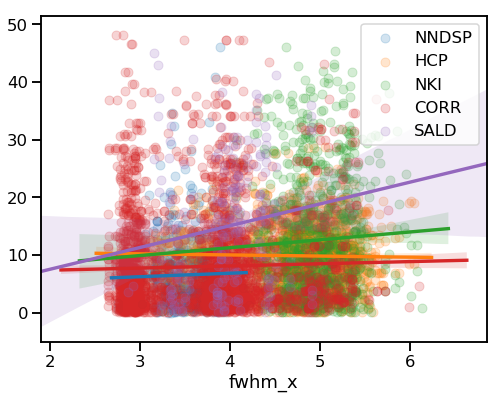

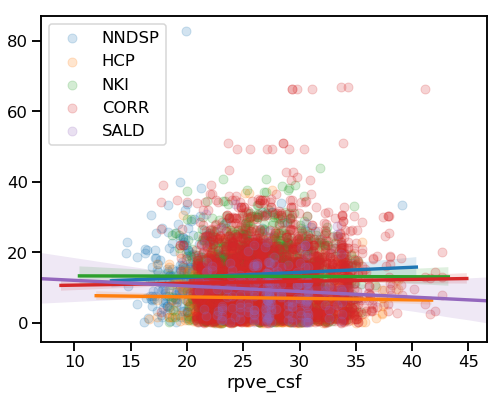

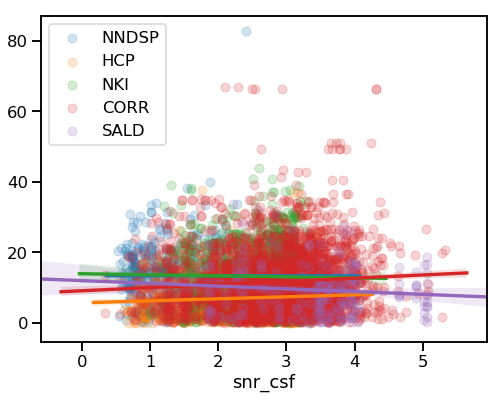

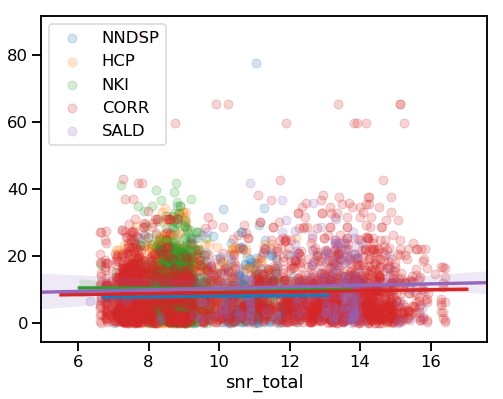

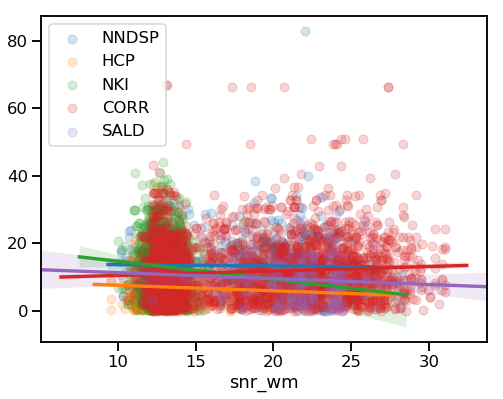

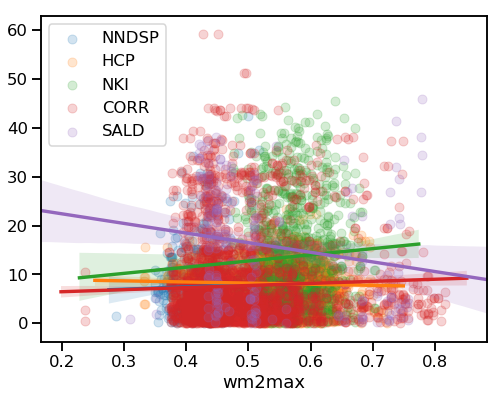

In [98]:
#for qc_metric, best_data in best_dataset_per_metric.items():
for qc_metric in df_sig_pvals.metric:
    plt.figure(figsize=(8,6))
    for data in ['nndsp', 'hcp', 'nki', 'corr', 'sald']:
        x = df_mae[df_mae.data_class == int(dataclass_mapping[data])][qc_metric]
        best_in_data = best_dataset_per_metric[qc_metric]
        simple_y = [abs(df_mae[df_mae.data_class == int(dataclass_mapping[data])].age.values[i] - 
                                df_mae[df_mae.data_class == int(dataclass_mapping[data])]['simple_'+qc_metric+'_pred'].values[i]) 
                     for i in range(len(df_mae[df_mae.data_class == int(dataclass_mapping[data])]))]
        
        sns.set_context('talk')
        sns.regplot(x, simple_y, label = data.upper(), scatter_kws={'alpha':0.2})
    plt.legend(loc='best')
    plt.savefig('/data/NNDSP/anal/analysis_notebooks/follow_up_analysis/figures/h2.4_simple_'+qc_metric+'.png', dpi=300)
    plt.show()